In [2]:
import pandas as pd

# Loading

In [3]:
# Read csv
df = pd.read_csv('..\\data\\processed\\final_df.csv', parse_dates=True, index_col=0)
df.index = pd.to_datetime(df.index)
df.head(2)

,Hour,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South),Lygon St (West),IsPublicHoliday,temp,humidity,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_Spring,Season_Summer,Season_Winter
2022-04-01 00:00:00,0,166.0,24.0,380.0,73.0,215.0,48.0,0,16.90,59,...,0,0,0,0,0,0,0,1,0,0
2022-04-01 01:00:00,1,108.0,9.0,198.0,79.0,156.0,11.0,0,17.28,58,...,0,0,0,0,0,0,0,1,0,0


In [4]:
train = df[df.index < "2024-05-01"]
test = df[df.index >= "2024-05-01"]


# SARIMA

In [5]:
train.columns

Index(['Hour', 'Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
       'Lygon St (West)', 'IsPublicHoliday', 'temp', 'humidity', 'rain_1h',
       'clouds_all', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', 'Weekday_7', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Season_Spring', 'Season_Summer', 'Season_Winter'],
      dtype='object')

## Staionary d

In [5]:
from statsmodels.tsa.stattools import adfuller

target_column = ['Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
       'Lygon St (West)']

for column in target_column:
    print(column)
    result = adfuller(train[column])
    print('p-value:', result[1])  # A p-value > 0.05 indicates non-stationarity.


Little Collins St-Swanston St (East)
p-value: 4.3999119450372294e-26
Faraday St-Lygon St (West)
p-value: 0.0
Melbourne Central
p-value: 1.1055394151069837e-26
Chinatown-Lt Bourke St (South)
p-value: 0.0
Lonsdale St (South)
p-value: 0.0
Lygon St (West)
p-value: 0.0


No differnecing needed

In [6]:
d = 0

## Seasonal

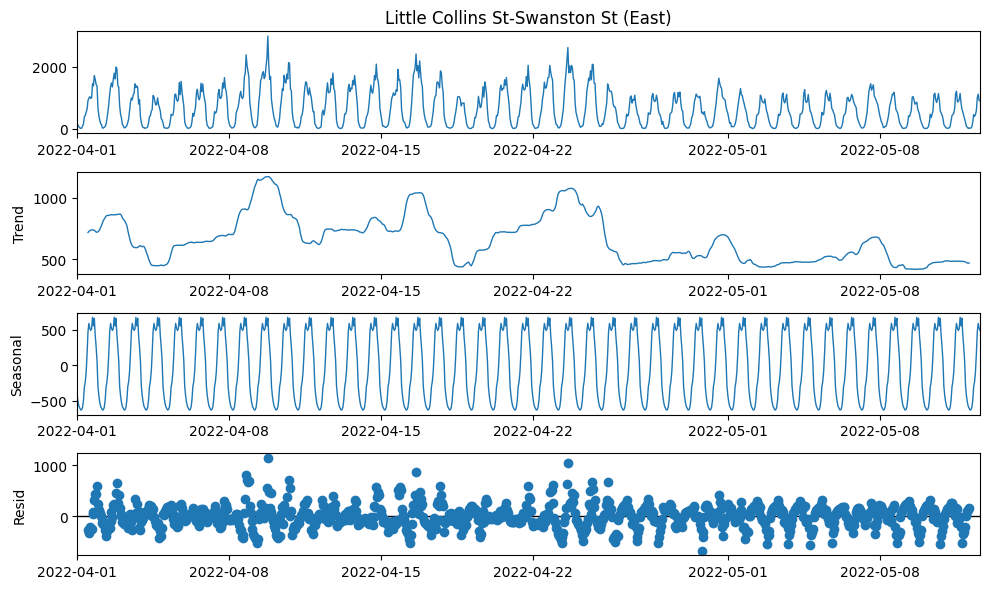

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_2 = train[:1000]

decomposition = seasonal_decompose(df_2['Little Collins St-Swanston St (East)'], model='additive', period=24)  # e.g., 24 for hourly data
fig = decomposition.plot()
# Make lines thinner
for ax in fig.axes:
    plt.setp(ax.lines, linewidth=1)

fig.set_size_inches(10, 6)  # Width x Height in inches
fig.tight_layout()  # Adjust spacing
plt.show()


In [8]:
S = 24

## Parameter search

In [ ]:
import itertools
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm  # For progress bar

# Define parameter ranges
p = q = range(0, 4)  # Range for p and q
d = 0                # Fixed d
P = D = Q = range(0, 3)  # Range for seasonal P, D, Q
m = 24               # Daily seasonality

train = train.asfreq('H')

# Generate all parameter combinations
pdq = [(p_val, d, q_val) for p_val in p for q_val in q]  # Fix d = 0
print("Non-seasonal combinations (p, d, q):", pdq)

seasonal_pdq = [(P_val, D_val, Q_val, m) for P_val in P for D_val in D for Q_val in Q]
print("Seasonal combinations (P, D, Q, m):", seasonal_pdq)

total_combinations = len(pdq) * len(seasonal_pdq)

# Initialize a dictionary to store the best results for each column
best_results = {}

columns = ['Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
       'Lygon St (West)']

# Iterate over columns
for column in columns:
    print(f"Processing column: {column}")
    
    # Reset best AIC and parameters for each column
    best_aic = float('inf')
    best_params = None
    
    # Progress bar
    progress_bar = tqdm(total=total_combinations, desc=f"Testing SARIMAX for {column}")
    
    # Grid search over all parameter combinations
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                # Fit the model
                model = SARIMAX(
                    train[column],
                    order=param,
                    seasonal_order=seasonal_param,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)

                # Check if the model is better
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (param, seasonal_param)

            except Exception as e:
                # Handle exceptions (e.g., convergence issues) silently
                pass

            # Update the progress bar
            progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()

    # Store the best parameters and AIC for this column
    best_results[column] = {'params': best_params, 'aic': best_aic}

    print(f"Best SARIMAX parameters for {column}: {best_params} with AIC: {best_aic}")

# Display the results for all columns
for col, result in best_results.items():
    print(f"Column: {col}, Best Params: {result['params']}, Best AIC: {result['aic']}")


Non-seasonal combinations (p, d, q): [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3)]
Seasonal combinations (P, D, Q, m): [(0, 0, 0, 24), (0, 0, 1, 24), (0, 0, 2, 24), (0, 1, 0, 24), (0, 1, 1, 24), (0, 1, 2, 24), (0, 2, 0, 24), (0, 2, 1, 24), (0, 2, 2, 24), (1, 0, 0, 24), (1, 0, 1, 24), (1, 0, 2, 24), (1, 1, 0, 24), (1, 1, 1, 24), (1, 1, 2, 24), (1, 2, 0, 24), (1, 2, 1, 24), (1, 2, 2, 24), (2, 0, 0, 24), (2, 0, 1, 24), (2, 0, 2, 24), (2, 1, 0, 24), (2, 1, 1, 24), (2, 1, 2, 24), (2, 2, 0, 24), (2, 2, 1, 24), (2, 2, 2, 24)]
Processing column: Faraday St-Lygon St (West)


Testing SARIMAX for Faraday St-Lygon St (West):   4%|▍         | 17/432 [33:01<16:12:28, 140.60s/it]c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Testing SARIMAX for Faraday St-Lygon St (West):   6%|▌         | 26/432 [1:33:40<41:32:54, 368.41s/it]c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Testing SARIMAX for Faraday St-Lygon St (West):   8%|▊         | 35/432 [2:14:25<17:24:56, 157.93s/it]c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizati

MemoryError: Unable to allocate 1.31 GiB for an array with shape (98, 98, 18264) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 988, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 1.31 GiB for an array with shape (98, 98, 18264) and data type float64
Testing SARIMAX for Faraday St-Lygon St (West):  14%|█▍        | 62/432 [5:28:24<22:44:40, 221.30s/it]  c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Testing SARIMAX for Faraday St-Lygon St (West):  15%|█▍        | 64/432 [6:11:45<67:03:51, 656.06s/it]c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

Column: Little Collins St-Swanston St (East): ((1, 0, 2), (1, 1, 1, 24)) with AIC: 230806.7825760926 <br>
Column: Faraday St-Lygon St (West), Best Params: ((1, 0, 2), (1, 1, 1, 24)), Best AIC: 190003.90829115754 <br>
Column: Melbourne Central, Best Params: ((1, 0, 2), (1, 1, 1, 24)), Best AIC: 233857.60412778181 <br>
Column: Chinatown-Lt Bourke St (South), Best Params: ((1, 0, 2), (1, 1, 1, 24)), Best AIC: 219997.16664512668 <br>
Column: Lonsdale St (South), Best Params: ((2, 0, 1), (1, 1, 1, 24)), Best AIC: 208037.09922881392 <br>
Column: Lygon St (West), Best Params: ((2, 0, 2), (1, 1, 1, 24)), Best AIC: 195383.3819879219 <br>

## Fit SARIMAX

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMAX model with identified parameters
sarimax_model = SARIMAX(train['Little Collins St-Swanston St (East)'],
                        order=(1, 0, 2),              # Replace with values from auto_arima
                        seasonal_order=(1, 1, 1, 24),  # Replace with values from auto_arima
                        enforce_stationarity=False,
                        enforce_invertibility=False)

# Fit the model
sarimax_results = sarimax_model.fit()

print(sarimax_results.summary())


c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                        SARIMAX Results                                         
Dep. Variable:     Little Collins St-Swanston St (East)   No. Observations:                18264
Model:                 SARIMAX(1, 0, 2)x(1, 1, [1], 24)   Log Likelihood             -115397.391
Date:                                  Sun, 01 Dec 2024   AIC                         230806.783
Time:                                          19:10:18   BIC                         230853.642
Sample:                                      04-01-2022   HQIC                        230822.183
                                           - 04-30-2024                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8201      0.003    242.502      0.000       0.813

## Test

In [8]:
start = test.index[0]
end = test.index[-1]

# Generate predictions with confidence intervals
test_predictions = sarimax_results.get_prediction(start=start, end=end)
predicted_mean = test_predictions.predicted_mean
confidence_intervals = test_predictions.conf_int()

# Combine predictions with the test data
test_results = test.copy()
test_results['Predicted'] = predicted_mean
test_results['Lower_CI'] = confidence_intervals.iloc[:, 0]
test_results['Upper_CI'] = confidence_intervals.iloc[:, 1]

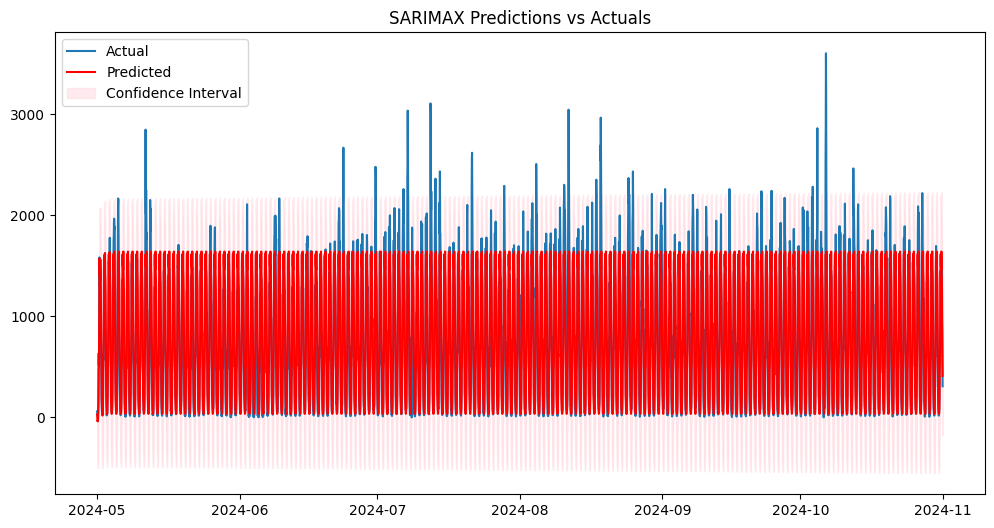

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Little Collins St-Swanston St (East)'], label='Actual')
plt.plot(test.index, test_results['Predicted'], label='Predicted', color='red')
plt.fill_between(test.index, 
                 test_results['Lower_CI'], 
                 test_results['Upper_CI'], 
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.title('SARIMAX Predictions vs Actuals')
plt.show()


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['Little Collins St-Swanston St (East)'], test_results['Predicted'])
rmse = np.sqrt(mean_squared_error(test['Little Collins St-Swanston St (East)'], test_results['Predicted']))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 197.42221512079846
RMSE: 282.94336208360846


## Check for Resid

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data['target_column'],
                order=(1, 1, 0),
                seasonal_order=(1, 0, 0, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(15, 8))


NameError: name 'data' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Residuals from the fitted model
residuals = sarimax_results.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.axhline(0, linestyle='--', color='r', alpha=0.7)
plt.show()


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.show()

# PACF plot
plot_pacf(residuals, lags=40)
plt.title('PACF of Residuals')
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test
ljung_box = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print(ljung_box)


# GARCH

# Try TBATS 

https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a